In [1]:
#!pip install fiona shapely scipy  # Uncomment if dependencies not installed

import fiona
import numpy as np
from shapely.geometry import shape
from shapely.ops import unary_union
from scipy.optimize import linear_sum_assignment

class TreeMatcher:
    def __init__(self, 
                 metric: str = 'iou',
                 merge_threshold: float = 0.7,
                 split_penalty: float = 0.3):
        """
        Args:
            metric: 'iou' or 'euclidean'
            merge_threshold: IoU threshold for merging split detections (0-1)
            split_penalty: Penalty weight for split detections in cost matrix
        """
        self.metric = metric
        self.merge_threshold = merge_threshold
        self.split_penalty = split_penalty

    def load_polygons(self, gpkg_path: str) -> list:
        """Load polygons from GPKG file with spatial validation"""
        with fiona.open(gpkg_path, "r") as src:
            return [self._validate_geometry(shape(feat["geometry"])) 
                    for feat in src if feat["geometry"]]

    def _validate_geometry(self, geom):
        """Ensure valid polygon geometry"""
        return geom if geom.is_valid else geom.buffer(0)

    def _calculate_iou(self, poly1, poly2) -> float:
        """Calculate Intersection over Union with robustness"""
        if not poly1.intersects(poly2):
            return 0.0
        intersection = poly1.intersection(poly2).area
        union = poly1.union(poly2).area
        return intersection / union if union > 0 else 0.0

    def _merge_split_detections(self, polygons: list) -> list:
        """Merge overlapping detections using hierarchical clustering"""
        merged = []
        for poly in sorted(polygons, key=lambda x: -x.area):
            if not merged or self._calculate_iou(poly, merged[-1]) < self.merge_threshold:
                merged.append(poly)
        return merged

    def create_cost_matrix(self, base_polygons, target_polygons) -> np.ndarray:
        """Build cost matrix with split detection awareness"""
        base = self._merge_split_detections(base_polygons)
        target = self._merge_split_detections(target_polygons)
        
        cost_matrix = np.zeros((len(base), len(target)))
        
        for i, b_poly in enumerate(base):
            for j, t_poly in enumerate(target):
                if self.metric == 'iou':
                    cost = 1 - self._calculate_iou(b_poly, t_poly)
                    # Add split penalty for multiple matches
                    if len(base) > len(target):
                        cost += self.split_penalty * (len(base)/len(target) - 1)
                else:  # Euclidean
                    cost = b_poly.centroid.distance(t_poly.centroid)
                cost_matrix[i, j] = cost
                
        return cost_matrix

    def match_trees(self, gpkg_path1: str, gpkg_path2: str) -> dict:
        """Main matching function with Hungarian algorithm"""
        base_polygons = self.load_polygons(gpkg_path1)
        target_polygons = self.load_polygons(gpkg_path2)
        
        cost_matrix = self.create_cost_matrix(base_polygons, target_polygons)
        row_ind, col_ind = linear_sum_assignment(cost_matrix)
        
        return {
            "matches": list(zip(row_ind, col_ind)),
            "cost_matrix": cost_matrix,
            "total_cost": cost_matrix[row_ind, col_ind].sum()
        }

In [2]:
# Initialize matcher with desired parameters
matcher = TreeMatcher(metric='iou', merge_threshold=0.7)

# Process GPKG files and get matches
result = matcher.match_trees('large_files/tiles_sit_om2_230103_randresize_full_50/crowns_map.gpkg',
                              'large_files/tiles_sit_om2_230103_randresize_full_50/crowns_map.gpkg')

print(f"Matched {len(result['matches'])} trees")
print(f"Total matching cost: {result['total_cost']:.2f}")


Matched 105 trees
Total matching cost: 0.00


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MplPolygon  # Critical import fix
from shapely.geometry import shape

class TreeMatcherWithVisualization(TreeMatcher):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._configure_plot_style()
    
    def _configure_plot_style(self):
        try:
            # Try modern seaborn style first
            plt.style.use('seaborn-v0_8-whitegrid')
        except OSError:
            # Fallback to basic style
            plt.style.use('ggplot')
        
        self.colors = {
            'base': '#1f77b4',
            'target': '#ff7f0e', 
            'match_line': '#2ca02c'
        }

    def _create_figure(self, title):
        fig, ax = plt.subplots(figsize=(12, 8))
        ax.set_title(title, fontsize=14, pad=20)
        ax.set_xlabel('X Coordinate (m)', fontsize=10)
        ax.set_ylabel('Y Coordinate (m)', fontsize=10)
        ax.grid(True, linestyle='--', alpha=0.7)
        return fig, ax

    def visualize_detections(self, gpkg_path1, gpkg_path2):
        """Visualize input detections before matching"""
        base_polygons = self.load_polygons(gpkg_path1)
        target_polygons = self.load_polygons(gpkg_path2)

        fig, ax = self._create_figure("Pre-Matching Detection Comparison")
        
        # Plot with different styles for base and target
        self._plot_polygon_set(ax, base_polygons, 
                             color=self.colors['base'], 
                             label='Base Survey')
        self._plot_polygon_set(ax, target_polygons,
                             color=self.colors['target'],
                             label='Target Survey', 
                             hatch='//')
        
        ax.legend(loc='upper right')
        plt.show()

    def _plot_polygon_set(self, ax, polygons, color, label, hatch=None):
        for poly in polygons:
            if poly.geom_type not in ['Polygon', 'MultiPolygon']:
                continue
                
            if poly.geom_type == 'MultiPolygon':
                geoms = poly.geoms
            else:
                geoms = [poly]

            for geom in geoms:
                patch = MplPolygon(
                    list(geom.exterior.coords),
                    closed=True,
                    fill=True,
                    alpha=0.4,
                    edgecolor=color,
                    facecolor=color,
                    hatch=hatch,
                    linewidth=0.8
                )
                ax.add_patch(patch)
                
        # Dummy element for legend
        ax.plot([], [], color=color, label=label, alpha=0.4)

    def visualize_matching_results(self, gpkg_path1, gpkg_path2, result):
        """Visualize matched pairs with connection lines"""
        base_polygons = self.load_polygons(gpkg_path1)
        target_polygons = self.load_polygons(gpkg_path2)

        fig, ax = self._create_figure("Tree Matching Results")
        
        # Plot both detection sets
        self._plot_polygon_set(ax, base_polygons, self.colors['base'], 'Base')
        self._plot_polygon_set(ax, target_polygons, self.colors['target'], 'Target')
        
        # Draw match connections
        for b_idx, t_idx in result['matches']:
            b_centroid = base_polygons[b_idx].centroid
            t_centroid = target_polygons[t_idx].centroid
            ax.plot(
                [b_centroid.x, t_centroid.x],
                [b_centroid.y, t_centroid.y],
                color=self.colors['match_line'],
                linestyle='--',
                linewidth=1.2,
                alpha=0.7
            )

        ax.legend()
        plt.show()

    def generate_report(self, result):
        """Print comprehensive matching report"""
        print(f"""
        {' Tree Matching Report ':-^50}
        Total Base Detections: {len(result['cost_matrix'])}
        Total Target Detections: {len(result['cost_matrix'][0])}
        Successful Matches: {len(result['matches'])} 
        Unmatched Base: {len(result['cost_matrix']) - len(result['matches'])}
        Unmatched Target: {len(result['cost_matrix'][0]) - len(result['matches'])}
        Total Matching Cost: {result['total_cost']:.4f}
        Average Match Quality: {result['total_cost']/len(result['matches']):.4f}
        """)

        # Print cost matrix summary
        print("\nCost Matrix Statistics:")
        print(f"Min cost: {np.min(result['cost_matrix']):.4f}")
        print(f"Max cost: {np.max(result['cost_matrix']):.4f}")
        print(f"Mean cost: {np.mean(result['cost_matrix']):.4f}")

    def export_matches(self, result, output_path):
        """Export matches to CSV file"""
        import csv
        with open(output_path, 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(['Base_Index', 'Target_Index', 'Match_Cost'])
            for b_idx, t_idx in result['matches']:
                writer.writerow([
                    b_idx,
                    t_idx,
                    f"{result['cost_matrix'][b_idx][t_idx]:.4f}"
                ])
        print(f"Exported {len(result['matches'])} matches to {output_path}")

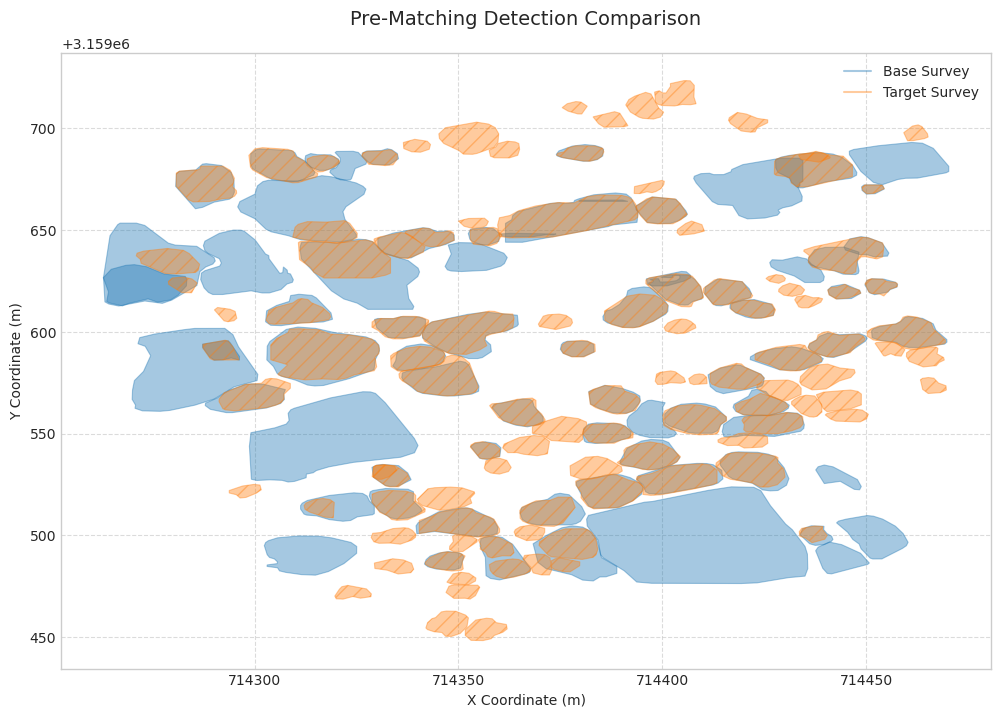


        -------------- Tree Matching Report --------------
        Total Base Detections: 73
        Total Target Detections: 105
        Successful Matches: 73 
        Unmatched Base: 0
        Unmatched Target: 32
        Total Matching Cost: 29.8676
        Average Match Quality: 0.4091
        

Cost Matrix Statistics:
Min cost: 0.0420
Max cost: 1.0000
Mean cost: 0.9941


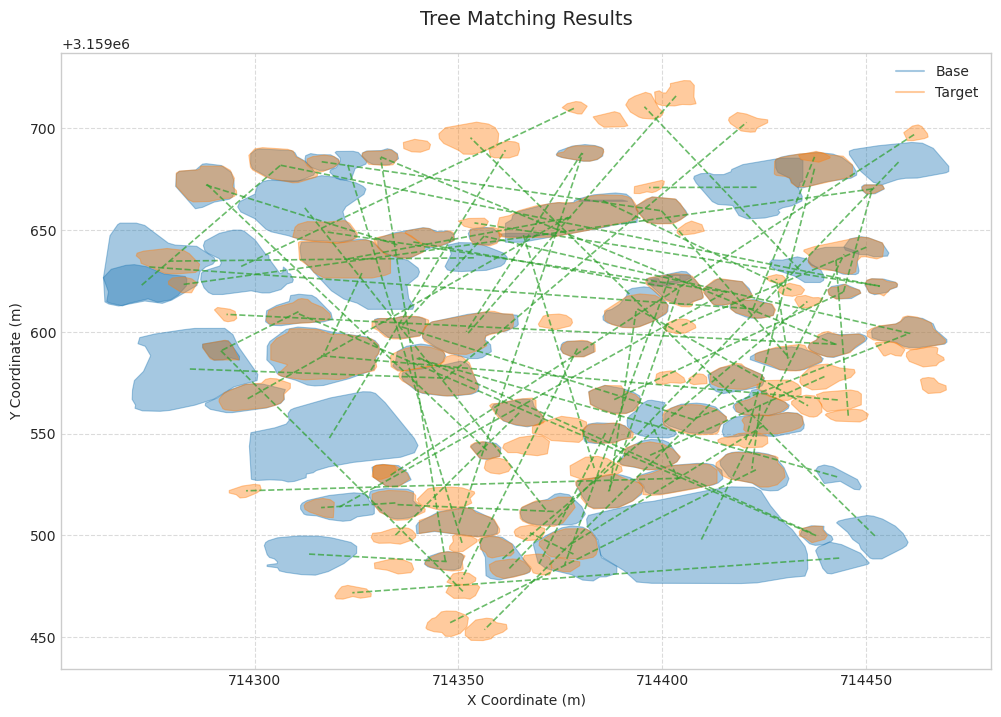

Exported 73 matches to matches_output.csv


In [9]:
# Initialize matcher with visualization capabilities
matcher = TreeMatcherWithVisualization(
    metric='iou',
    merge_threshold=0.7,
    split_penalty=0.4
)

# 1. Visualize input detections
matcher.visualize_detections('large_files/tiles_sit_om2/crowns_map.gpkg',
                              'large_files/tiles_sit_om2_230103_randresize_full_50/crowns_map.gpkg')

# 2. Perform matching
result = matcher.match_trees('large_files/tiles_sit_om2/crowns_map.gpkg', 
                             'large_files/tiles_sit_om2_230103_randresize_full_50/crowns_map.gpkg')

# 3. Generate comprehensive report
matcher.generate_report(result)

# 4. Visualize matches
matcher.visualize_matching_results('large_files/tiles_sit_om2/crowns_map.gpkg', 'large_files/tiles_sit_om2_230103_randresize_full_50/crowns_map.gpkg', result)

# 5. Export results to CSV
matcher.export_matches(result, 'matches_output.csv')

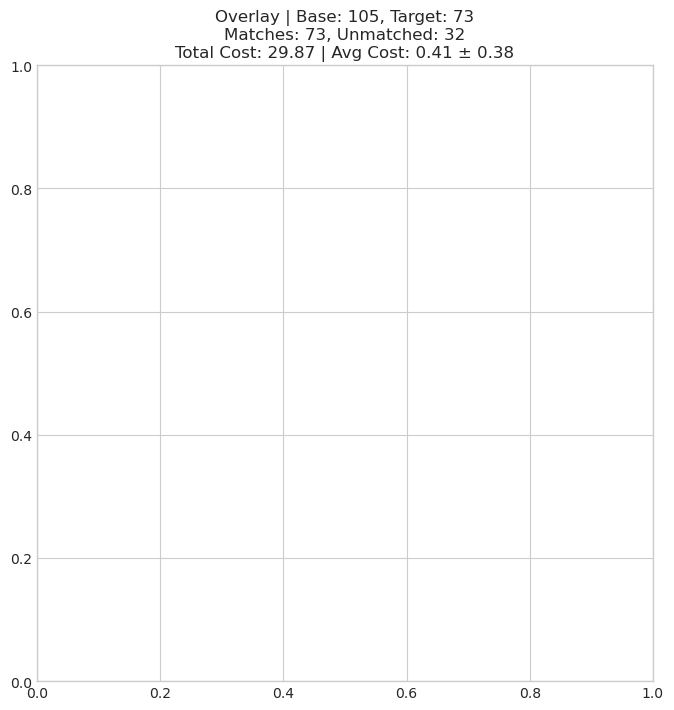

/tmp/ipykernel_216771/2305380313.py:124: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


ValueError: Image size of 480834619x2126489290 pixels is too large. It must be less than 2^23 in each direction.

<Figure size 1600x800 with 3 Axes>

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MplPolygon, ConnectionPatch
from matplotlib.colors import Normalize
from scipy.optimize import linear_sum_assignment
from shapely.geometry import shape
import fiona

class TreeTracker:
    def __init__(self, metric='iou', merge_threshold=0.7, split_penalty=0.4):
        self.metric = metric
        self.merge_threshold = merge_threshold
        self.split_penalty = split_penalty
        self._configure_styles()
        
    def _configure_styles(self):
        plt.style.use('seaborn-v0_8-whitegrid')
        self.colors = {
            'base': '#2166ac',    # Darker blue
            'target': '#b2182b',  # Darker red
        }
        self.cmap = plt.get_cmap('viridis')

    def load_polygons(self, gpkg_path):
        with fiona.open(gpkg_path, "r") as src:
            return [self._validate_geom(shape(feat["geometry"])) for feat in src]

    def _validate_geom(self, geom):
        return geom if geom.is_valid else geom.buffer(0)

    def match_trees(self, path1, path2):
        base = self._merge_polygons(self.load_polygons(path1))
        target = self._merge_polygons(self.load_polygons(path2))
        
        self.base_polygons = base
        self.target_polygons = target
        self.cost_matrix = self._create_cost_matrix(base, target)
        row_idx, col_idx = linear_sum_assignment(self.cost_matrix)
        self.matches = list(zip(row_idx, col_idx))

        # precompute cost list for stats
        self.match_costs = [self.cost_matrix[b, t] for b, t in self.matches]
        return self.matches

    def _merge_polygons(self, polygons):
        merged = []
        for poly in sorted(polygons, key=lambda x: -x.area):
            if not merged or (poly.intersection(merged[-1]).area / poly.area) < self.merge_threshold:
                merged.append(poly)
        return merged

    def _create_cost_matrix(self, base, target):
        return np.array([[1 - self._iou(a, b) for b in target] for a in base])

    def _iou(self, poly1, poly2):
        inter = poly1.intersection(poly2).area
        union = poly1.area + poly2.area - inter
        return inter / union if union > 0 else 0.0

    def plot_overlay(self):
        fig, ax = plt.subplots(figsize=(10, 8))
        for poly in self.base_polygons:
            self._draw_polygon(ax, poly, self.colors['base'], alpha=0.4)
        for poly in self.target_polygons:
            self._draw_polygon(ax, poly, self.colors['target'], alpha=0.4, hatch='//')
        ax.set_aspect('equal')
        ax.set_title(
            f"Overlay | Base: {len(self.base_polygons)}, Target: {len(self.target_polygons)}\n"
            f"Matches: {len(self.matches)}, Unmatched: {abs(len(self.base_polygons)-len(self.target_polygons))}\n"
            f"Total Cost: {sum(self.match_costs):.2f} | "
            f"Avg Cost: {np.mean(self.match_costs):.2f} ± {np.std(self.match_costs):.2f}",
            fontsize=12
        )
        plt.show()

    def plot_matches_with_costs(self):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharey=True)
        # Side 1: Base
        for poly in self.base_polygons:
            self._draw_polygon(ax1, poly, self.colors['base'], alpha=0.6)
        ax1.set_title("Base Detections")
        ax1.set_aspect('equal')
        ax1.set_xlabel("X (m)")
        ax1.set_ylabel("Y (m)")
        # Side 2: Target
        for poly in self.target_polygons:
            self._draw_polygon(ax2, poly, self.colors['target'], alpha=0.6)
        ax2.set_title("Target Detections")
        ax2.set_aspect('equal')
        ax2.set_xlabel("X (m)")

        # Normalize for colormap
        norm = Normalize(vmin=min(self.match_costs), vmax=max(self.match_costs))
        # Draw connections
        for (b_idx, t_idx), cost in zip(self.matches, self.match_costs):
            b_c = self.base_polygons[b_idx].centroid
            t_c = self.target_polygons[t_idx].centroid
            color = self.cmap(norm(cost))
            con = ConnectionPatch(
                xyA=(t_c.x, t_c.y), coordsA=ax2.transData,
                xyB=(b_c.x, b_c.y), coordsB=ax1.transData,
                arrowstyle='-', linestyle='--', linewidth=1.5, color=color, alpha=0.7
            )
            fig.add_artist(con)
            # midpoint in figure coords for annotation
            mid_fig = fig.transFigure.inverted().transform(
                ( (ax1.transData.transform((b_c.x, b_c.y))[0] + ax2.transData.transform((t_c.x, t_c.y))[0]) / 2,
                  (ax1.transData.transform((b_c.x, b_c.y))[1] + ax2.transData.transform((t_c.x, t_c.y))[1]) / 2 )
            )
            fig.text(mid_fig[0], mid_fig[1], f"{cost:.2f}", ha='center', va='center', fontsize=8, color=color)

        # Colorbar
        sm = plt.cm.ScalarMappable(cmap=self.cmap, norm=norm)
        sm.set_array([])
        cbar = fig.colorbar(sm, ax=(ax1, ax2), fraction=0.046, pad=0.04)
        cbar.set_label('Matching Cost')

        fig.suptitle(
            f"Tree Tracking | Matches: {len(self.matches)}\n"
            f"Total Cost: {sum(self.match_costs):.2f} | "
            f"Avg Cost: {np.mean(self.match_costs):.2f} ± {np.std(self.match_costs):.2f}",
            fontsize=14
        )
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

    def _draw_polygon(self, ax, poly, color, alpha=1.0, hatch=None):
        geoms = poly.geoms if poly.geom_type == 'MultiPolygon' else [poly]
        for g in geoms:
            patch = MplPolygon(
                list(g.exterior.coords),
                closed=True,
                edgecolor=color,
                facecolor=color,
                alpha=alpha,
                linewidth=0.8,
                hatch=hatch
            )
            ax.add_patch(patch)

# Usage
if __name__ == "__main__":
    tracker = TreeTracker(metric='iou', merge_threshold=0.65)
    tracker.match_trees(
        "large_files/tiles_sit_om2_230103_randresize_full_50/crowns_map.gpkg",
        "large_files/tiles_sit_om2/crowns_map.gpkg"
    )
    tracker.plot_overlay()
    tracker.plot_matches_with_costs()

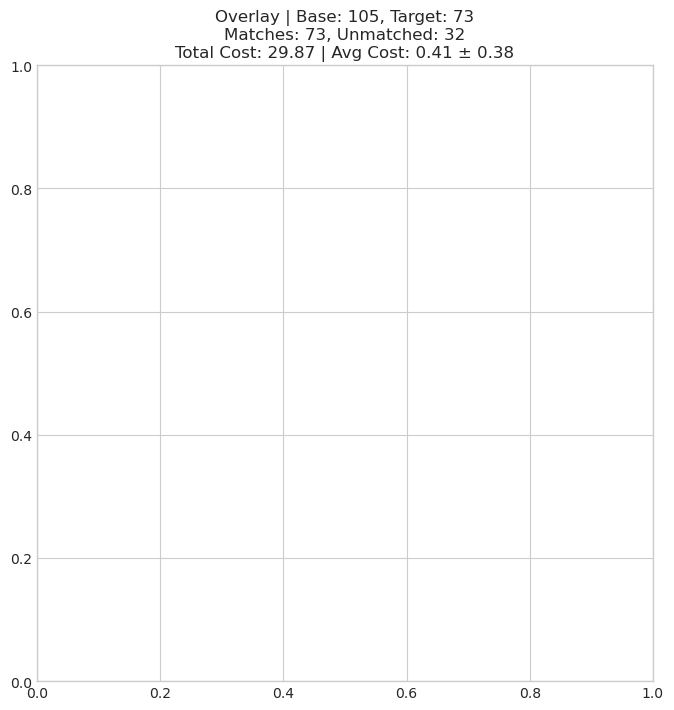

/tmp/ipykernel_216771/2305380313.py:124: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


ValueError: Image size of 480834619x2126489290 pixels is too large. It must be less than 2^23 in each direction.

<Figure size 1600x800 with 3 Axes>

In [14]:
tracker = TreeTracker(metric='iou', merge_threshold=0.65)
tracker.match_trees("large_files/tiles_sit_om2_230103_randresize_full_50/crowns_map.gpkg",
                     "large_files/tiles_sit_om2/crowns_map.gpkg")

# Generate both visualizations
tracker.plot_overlay()
tracker.plot_matches_with_costs()
